##### Import

In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install regressors

In [4]:
#System imports
import sys
import glob
import os
import subprocess
import shutil
import datetime
from functools import reduce

#Data manipulation imports
import pandas as pd
import numpy as np
from regressors import stats
import math
import re
import itertools
import pickle

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

In [5]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

#### Data Preparation

##### Read Data

In [7]:
df_full = pd.read_csv('/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/data/fulldata_impute.csv')

In [ ]:
df_full.columns

Index(['dsny_namecode', 'year', 'time', 'cont', 'ton', 'namecode_tds', 'SD',
       'units_S8', 'units_current', 'units_total', 'number_rental_rooms',
       'population_S8', 'population_PH', 'population_total',
       'residential_buildings', 'non-residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 'net_dev_sqft', 'acres_nopark',
       'bldg_coverage_sqft', 'cubage_cuft', 'development_cost',
       'families_on_fixed_income', 'ave_r_per_unit', 'density_PopPerSqFt',
       'density_PopPerDevFt', 'density_PopPerCubage',
       'cost_per_rental_room_ab', 'bldg_land_ratio', 'avg_m_gross_rent',
       'pct_families_on_fixed_income', 'dev_name', 'extcomp', 'waste_yard',
       'intcomp', 'rec_bins', 'balers', 'bulk_conts', 'per_unit_rb',
       'per_capita_rb', 'Avg Temperature', 'Precipitation', 'Snowdepth',
       'label_n4', 'C1', 'C2', 'C3', 'C4', 'HeavyPre', 'Snow', 'month',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'Septem

##### Dataset 1: All consolidations

In [9]:
df_model = df_full[df_full.time < '2021-09-01']
df_validation = df_full[df_full.time > '2021-08-01']

In [ ]:
if len(df_model) + len(df_validation) == len(df_full):
  print('Split is successful.')

Split is successful.


In [ ]:
#df_model.to_csv('/gdrive/MyDrive/000 Spring 2022/Thesis Capstone/Data/Interim/modeldata_impute.csv', index = False)
#df_validation.to_csv('/gdrive/MyDrive/000 Spring 2022/Thesis Capstone/Data/Interim/validationdata_impute.csv', index = False)

##### Dataset 2: Remove outliers 

In [8]:
outlier = ['baruch', 'monterey', 'cassidylafayette', 'drewhamilton', 'careygardens', 'wyckoffgardens', 
           'morrisaniaairrights', 'redfern', 'baileyavenuewest193rdstreet', 'audubon', 'sheepsheadbay', 
           'campos', 'taylor', 'chelsea', 'seward']

In [10]:
df_model = df_model[~df_model['dsny_namecode'].isin(outlier)].reset_index(drop = True)
df_validation = df_validation[~df_validation['dsny_namecode'].isin(outlier)].reset_index(drop = True)

##### Shuffling

In [11]:
df_model = df_model.sample(frac=1)

##### Features

In [12]:
# drop columns with NaN value: pct family on fixed income
df_model = df_model.dropna(axis = 1)

In [ ]:
df_model.columns

Index(['dsny_namecode', 'year', 'time', 'cont', 'ton', 'namecode_tds', 'SD',
       'units_S8', 'units_current', 'units_total', 'number_rental_rooms',
       'population_S8', 'population_PH', 'population_total',
       'residential_buildings', 'non-residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 'net_dev_sqft', 'acres_nopark',
       'bldg_coverage_sqft', 'cubage_cuft', 'development_cost',
       'families_on_fixed_income', 'ave_r_per_unit', 'density_PopPerSqFt',
       'density_PopPerDevFt', 'density_PopPerCubage',
       'cost_per_rental_room_ab', 'bldg_land_ratio', 'avg_m_gross_rent',
       'dev_name', 'extcomp', 'waste_yard', 'intcomp', 'rec_bins', 'balers',
       'bulk_conts', 'per_unit_rb', 'per_capita_rb', 'Avg Temperature',
       'Precipitation', 'Snowdepth', 'label_n4', 'C1', 'C2', 'C3', 'C4',
       'HeavyPre', 'Snow', 'month', 'January', 'February', 'March', 'April',
       'May', 'June', 'July', 'August', 'September', 'October', 'November',
       'De

In [13]:
var_binary = ['SD', 'C1', 'C2', 'C3', 'C4', 
              'pandemic', 'HeavyPre', 'Snow']

var_numeric = ['units_total', 
               #'number_rental_rooms','population_total',
       'residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 
       'net_dev_sqft', 'acres_nopark',
       'nondev_sqft', 'park_acres', 
       'bldg_coverage_sqft', 
       'cubage_cuft', 
       'bldg_land_ratio', 
       'development_cost', 'cost_per_rental_room_ab', 
       'families_on_fixed_income', 'avg_m_gross_rent',
       'ave_r_per_unit', 
       'density_PopPerSqFt','density_PopPerDevFt', 'density_PopPerCubage',
        'per_unit_rb', 'per_capita_rb',
        'ave_height', 'ave_bldg_sqft',
        'Avg Temperature']

# 'population_S8', 'population_PH', 

In [14]:
X_num = df_model[var_numeric].values
X_bi = df_model[var_binary].values

y = df_model['rolling_ton']

##### Scaling

In [15]:
# Standardize numeric variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num = scaler.fit_transform(df_model[var_numeric].values)

In [ ]:
# Normalize numeric variables
#from sklearn.preprocessing import Normalizer
#normalizer = Normalizer()
#X_num = normalizer.fit_transform(df_model[var_numeric].values)

In [ ]:
# Standardize y
#scaler = StandardScaler()
#y_std = scaler.fit_transform(df_model['rolling_ton'].values.reshape(-1, 1))

##### Train Test Split

In [55]:
Xy = np.hstack((X_num, X_bi, y.values.reshape(-1, 1)))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(Xy[:, :-1], Xy[:,-1], train_size = .75, random_state=0)
print("Train sample (X):", len(X_train))
print("Train sample (y):", len(y_train))
print("Test sample (X):", len(X_test))
print("Test sample (y):", len(y_test))

Train sample (X): 4611
Train sample (y): 4611
Test sample (X): 1537
Test sample (y): 1537


In [57]:
X_train.shape

(4611, 33)

## Linear Models

##### OLS Regression

In [58]:
lr_OLS = LinearRegression().fit(X_train, y_train)

y_pred_train = lr_OLS.predict(X_train)
y_pred_test = lr_OLS.predict(X_test)

print("Training Set Score: %.2f" % lr_OLS.score(X_train, y_train))
print("Mean Squared Error (training set): %.2f" % mean_squared_error(y_train, y_pred_train))
print("Testing Set Score: %.2f" % lr_OLS.score(X_test, y_test))
print("Mean Squared Error (testing set): %.2f" % mean_squared_error(y_test, y_pred_test))

Training Set Score: 0.87
Mean Squared Error (training set): 305.53
Testing Set Score: 0.86
Mean Squared Error (testing set): 338.94


In [59]:
result = pd.DataFrame(columns = ['Predictors', 'Coefficients', 'p_values'])
result['Predictors'] = var_binary+ var_numeric
result['Coefficients'] = lr_OLS.coef_
result['p_values'] = stats.coef_pval(lr_OLS, X_train.astype(float), y_train.astype(float))[1:]
result['*'] = result['p_values']<0.05
result 

,Predictors,Coefficients,p_values,*
0,SD,1.492396e+01,9.434641e-06,True
1,C1,-1.083848e+00,2.375793e-01,False
2,C2,-1.566262e+00,1.302538e-02,True
3,C3,1.053942e+15,0.000000e+00,True
4,C4,-2.325793e+14,0.000000e+00,True
5,pandemic,-9.424479e+14,0.000000e+00,True
6,HeavyPre,2.081001e+14,0.000000e+00,True
7,Snow,-1.998864e+14,0.000000e+00,True
8,units_total,4.415026e+13,0.000000e+00,True
9,residential_buildings,-1.218871e+01,2.331468e-14,True


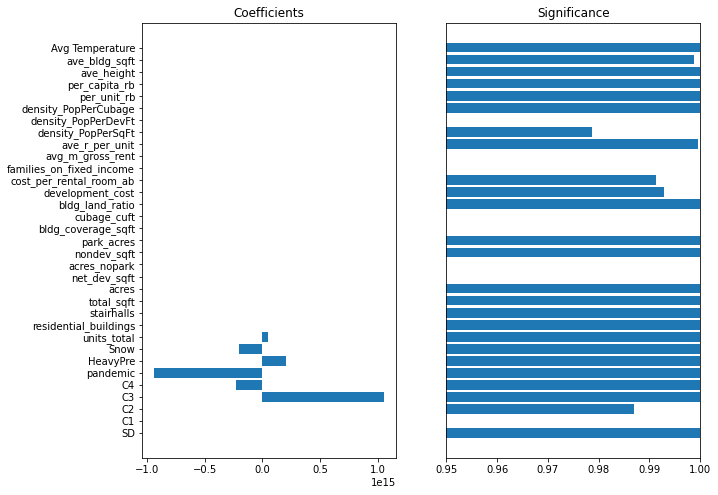

In [60]:
fig, ax = plt.subplots(figsize=(10, 8), nrows = 1, ncols = 2)

ax[0].barh(y = result['Predictors'], width = result['Coefficients'])
ax[0].set_title("Coefficients", fontsize=14)
ax[0].set_title('Coefficients')
#ax[0].set_xticklabels(  ax[0].get_xticklabels(),rotation=45, ha='right')
#plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         #rotation_mode="anchor")
#plt.grid()

ax[1].barh(y = result['Predictors'], width = 1- result['p_values'])
ax[1].set_yticks([])
ax[1].set_title('Significance')
plt.xlim(0.95, 1)

plt.show()


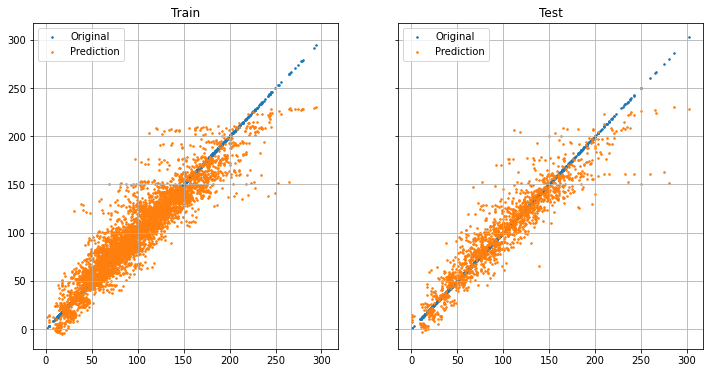

In [61]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

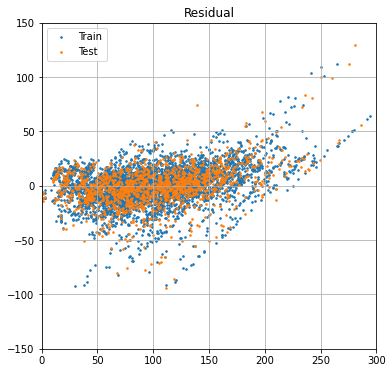

In [62]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [64]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/models/Dataset_without_Outlier/OLS.sav'
pickle.dump(lr_OLS, open(filename, 'wb'))

##### Lasso

In [65]:
lr_lasso = Lasso().fit(X_train, y_train) # trained model
y_pred_train = lr_lasso.predict(X_train)
y_pred_test = lr_lasso.predict(X_test)

print("Training score: %.3f" % lr_lasso.score(X_train, y_train))
print("Testing score: %.3f" % lr_lasso.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

print("Number of features used:", np.sum(lr_lasso.coef_ != 0))

Training score: 0.850
Testing score: 0.845
Mean Squared Error: 341.808
Mean Squared Error 381.783
Number of features used: 10


In [66]:
# With alpha = 0.001
lasso = Lasso(alpha=0.001).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.867
Test set score: 0.862
Mean squared error (training set): 303.50
Mean squared error (test set): 339.00
Number of features used: 31


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.331e+05, tolerance: 1.052e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [67]:
# With alpha = 0.01
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.867
Test set score: 0.862
Mean squared error (training set): 303.81
Mean squared error (test set): 339.18
Number of features used: 30


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.669e+04, tolerance: 1.052e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [68]:
# With alpha = 0.5
lasso = Lasso(alpha=0.5).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.859
Test set score: 0.854
Mean squared error (training set): 321.49
Mean squared error (test set): 359.34
Number of features used: 15


In [69]:
# With alpha = 1
lasso = Lasso(alpha=1).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.850
Test set score: 0.845
Mean squared error (training set): 341.81
Mean squared error (test set): 381.78
Number of features used: 10


In [54]:
# With alpha = 2
lasso = Lasso(alpha=2).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.839
Test set score: 0.823
Mean squared error (training set): 375.40
Mean squared error (test set): 410.61
Number of features used: 8


In [70]:
# With alpha = 5
lasso = Lasso(alpha=5).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.779
Test set score: 0.770
Mean squared error (training set): 504.48
Mean squared error (test set): 567.09
Number of features used: 5


##### Lasso - Lambda Selection

In [79]:
# Create a list of lambdas (alpha) from 0 to 20, evenly spaced 1000 numbers
lambdas = np.linspace(0, 5,1000)

# Create empty lists
list_train = [] # it will store train R2
list_test = [] # it will stroe test R2
list_gap = [] # it will store gap values between train R2 and test R2
list_num_features = [] # it will store the number of features used for modeling

list_train_e = [] # it will store train R2
list_test_e = [] # it will stroe test R2
list_gap_e = [] # it will store gap values between train R2 and test R2

for alpha in lambdas:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train) # Train ridge model using specified alpha (lambda)
    
    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)

    list_train.append(lasso.score(X_train, y_train))
    list_test.append(lasso.score(X_test, y_test))
    list_gap.append(np.abs(lasso.score(X_train, y_train) - lasso.score(X_test, y_test)))
    list_num_features.append(np.sum(lasso.coef_ != 0))


    list_train_e.append(mean_squared_error(y_train, y_pred_train))
    list_test_e.append(mean_squared_error(y_test, y_pred_test))
    list_gap_e.append(np.abs(mean_squared_error(y_train, y_pred_train)-mean_squared_error(y_test, y_pred_test)))


print ("The list of R2 values (training set):", list_train[:3]) # print only first three itmes due to the length
print ("The list of R2 values (test set):", list_test[:3]) # print only first three itmes due to the length
print ("The list of gap between two values:", list_gap[:3]) # print only first three itmes due to the length
print ("The list of #of used features:", list_num_features[:3])

The list of R2 values (training set): [0.8669530978676298, 0.8669162231761556, 0.8668158016301934]
The list of R2 values (test set): [0.8623654204651003, 0.8623638425685793, 0.8622989577276432]
The list of gap between two values: [0.004587677402529411, 0.004552380607576234, 0.004516843902550249]
The list of #of used features: [33, 31, 30]


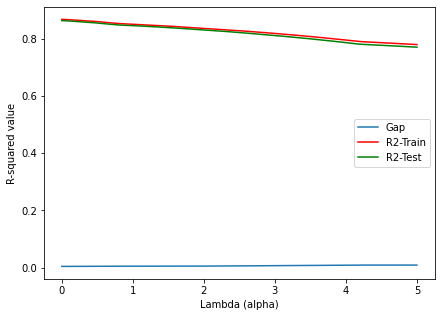

In [80]:
plt.figure(figsize=(7,5))

plt.plot(lambdas, list_gap, label='Gap')
plt.plot(lambdas, list_train, c='Red', label='R2-Train') 
plt.plot(lambdas, list_test, c='Green', label='R2-Test')

plt.xlabel("Lambda (alpha)")
plt.ylabel("R-squared value")

plt.legend()

In [81]:
p = list_gap.index(min(list_gap))

In [ ]:
list_gap

In [82]:
lambdas[p]

0.15515515515515516

In [83]:
final_lasso = Lasso(alpha=lambdas[p]).fit(X_train, y_train)

# Predict values based on train set (after this step, we will compare y_train vs, y_pred)
y_pred_train = final_lasso.predict(X_train)

# Model performance (training model)
print ("Training set score: %.2f"% final_lasso.score(X_train, y_train))
print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, y_pred_train))

# Predict values based on test set
y_pred_test = final_lasso.predict(X_test)

# Evaluation of our test
print ("Test set score: %.2f"% final_lasso.score(X_test, y_test))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, y_pred_test))

print ("The number of features used =",np.sum(final_lasso.coef_ != 0))

Training set score: 0.86
Mean squared error (training set): 308.53
Test set score: 0.86
Mean squared error (test set): 343.82
The number of features used = 21


In [84]:
result = pd.DataFrame(columns = ['Predictors', 'Coefficients', 'p_values'])
result['Predictors'] = var_numeric + var_binary
result['Coefficients'] = final_lasso.coef_
result['p_values'] = stats.coef_pval(final_lasso, X_train.astype(float), y_train.astype(float))[1:]
result['*'] = result['p_values']<0.01
#result 

In [85]:
result = result.sort_values(by = 'p_values', ascending = False)

Text(0.5, 1.0, '$\\lambda = 0.16$')

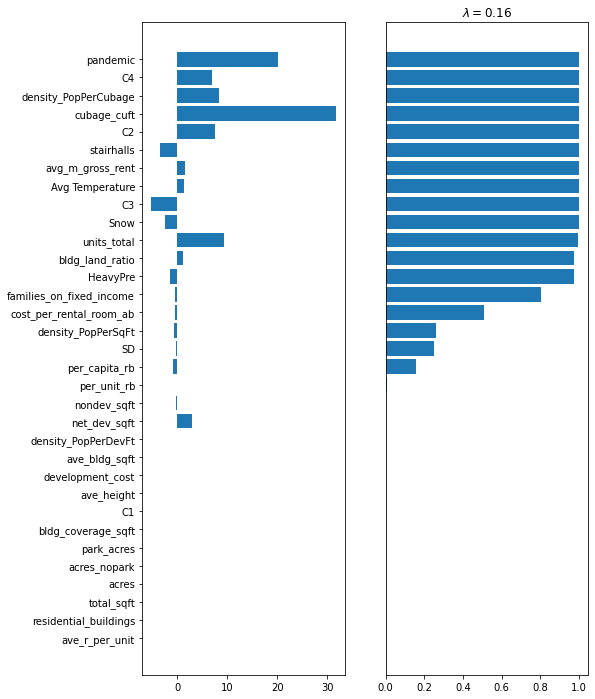

In [86]:
plt.figure(figsize=(8, 12))

plt.subplot(1, 2, 1)
plt.barh(y = result['Predictors'], width = result['Coefficients'])
#plt.xticks(rotation=45, ha='right')
#plt.axis('off')
#plt.grid()

plt.subplot(1, 2, 2)
plt.barh(y = result['Predictors'], width = 1- result['p_values'])
#plt.xticks(rotation=45, ha='right')
#plt.ylim(0.99, 1)
plt.yticks([])
plt.title('$\lambda = {}$'.format(round(lambdas[p], 2)))

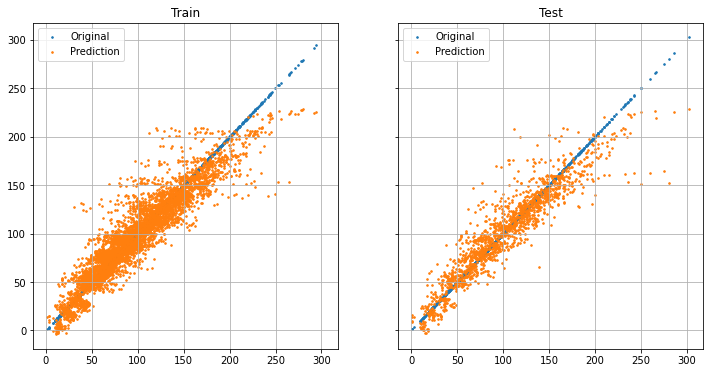

In [87]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

In [88]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/models/Dataset_without_Outlier/Lasso.sav'
pickle.dump(final_lasso, open(filename, 'wb'))

## Decision Tree

In [89]:
from sklearn import tree

##### DT, full tree

In [90]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [91]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 1.000
Testing score: 0.923
Mean Squared Error: 0.000
Mean Squared Error 188.534


In [92]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by = ['Importance'])

#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

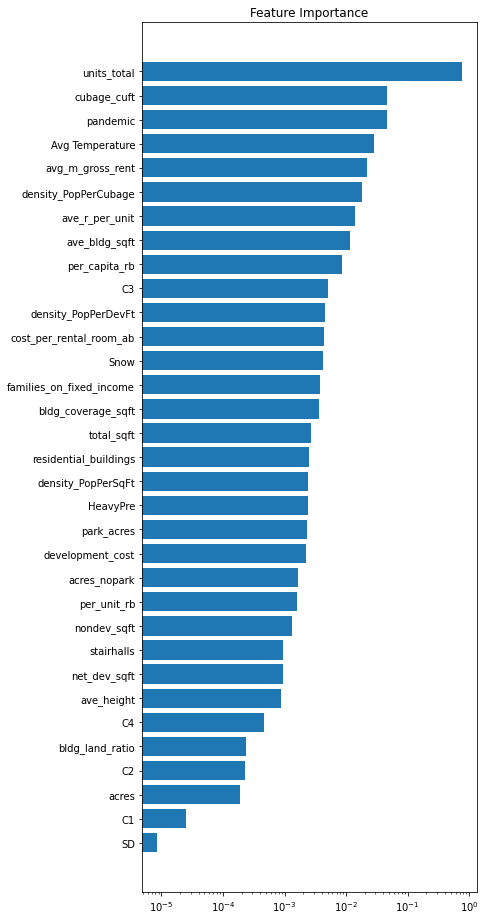

In [93]:
fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log = True)
# plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.show()

##### DT, Maxdepth = 10

In [ ]:
# max_depth = 10
clf = tree.DecisionTreeRegressor(max_depth = 10)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.959
Testing score: 0.931
Mean Squared Error: 96.857
Mean Squared Error 163.804


In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
tree.plot_tree(clf)

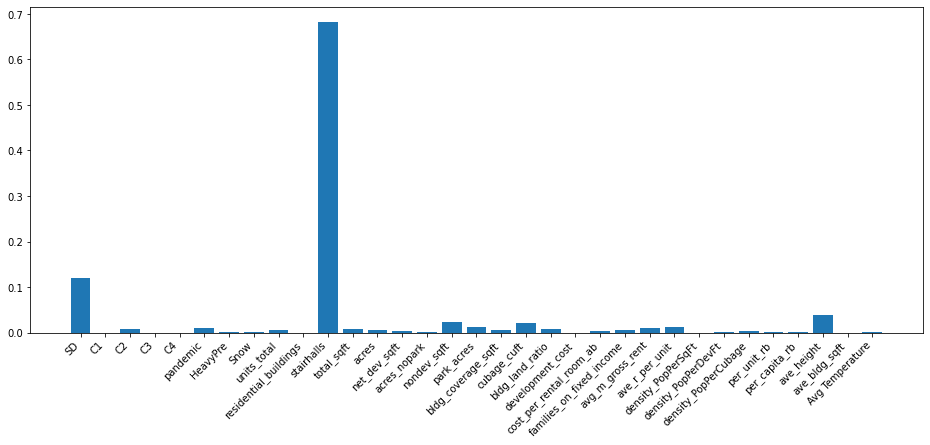

In [ ]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_binary+var_numeric
result['Importance'] = clf.feature_importances_
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (16, 6))
plt.bar(x = result['Predictors'], height = result['Importance'])
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
clf.decision_path(X_train)

<5229x1411 sparse matrix of type '<class 'numpy.int64'>'
	with 57283 stored elements in Compressed Sparse Row format>

##### DT, Maxdepth = 4

In [ ]:
# max_depth = 4
clf = tree.DecisionTreeRegressor(max_depth = 4)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.778
Testing score: 0.780
Mean Squared Error: 0.222
Mean Squared Error 0.219


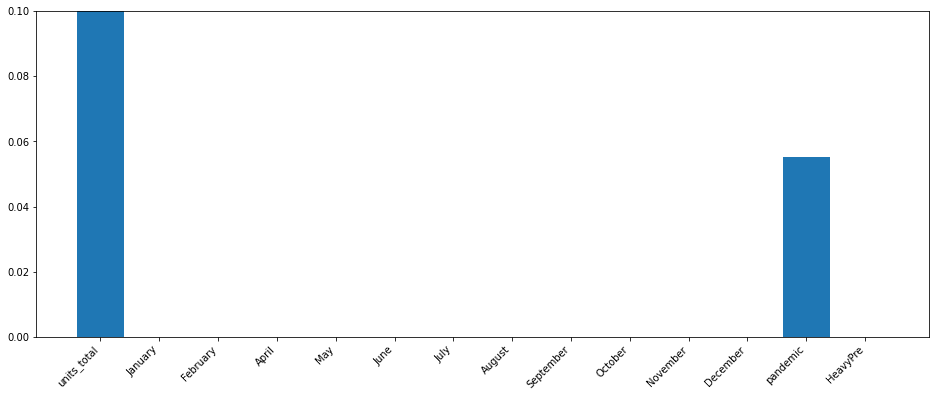

In [ ]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_list
result['Importance'] = clf.feature_importances_
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (16, 6))
plt.bar(x = result['Predictors'], height = result['Importance'])
plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(32, 16))
tree.plot_tree(clf,feature_names = var_list, fontsize = 10)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

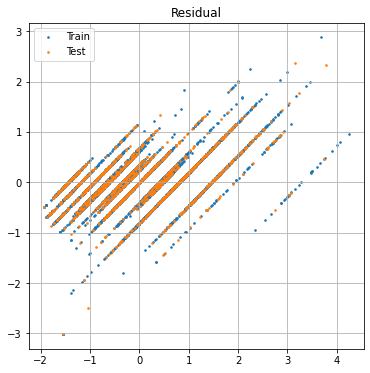

In [ ]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
#plt.xlim(0, 300)
#plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

##### DT, GridSearch

In [94]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(5,15)}
DT = tree.DecisionTreeRegressor()
clf = GridSearchCV(DT, parameters)
clf.fit(X_train,y_train)
print('Best parameters:', clf.best_params_)
print('Score from cross-validation: {:.5f}'.format(clf.best_score_))

Best parameters: {'max_depth': 9}
Score from cross-validation: 0.92733


In [97]:
clf = tree.DecisionTreeRegressor(max_depth = 9)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.962
Testing score: 0.935
Mean Squared Error: 87.201
Mean Squared Error 161.009


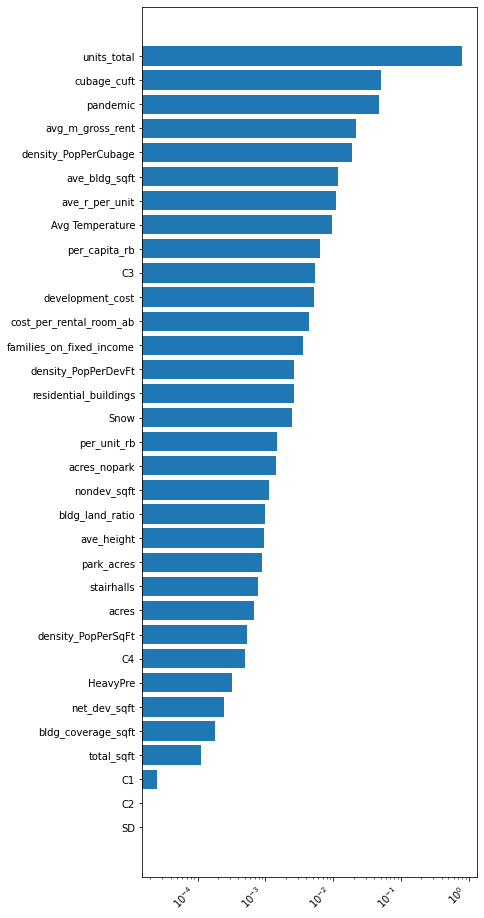

In [98]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by = 'Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

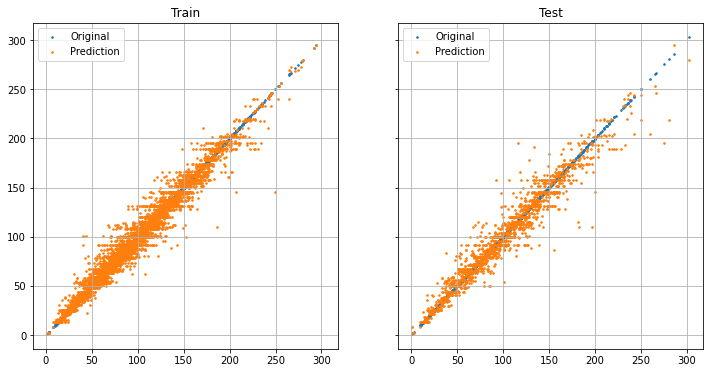

In [99]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

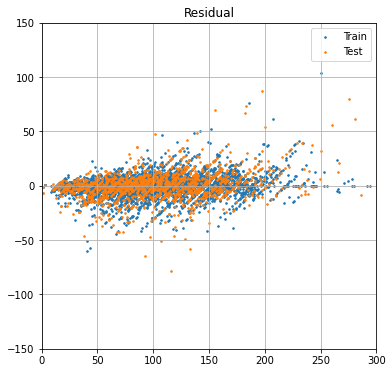

In [100]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [101]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/models/Dataset_without_Outlier/DT.sav'
pickle.dump(clf, open(filename, 'wb'))

## Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [103]:
parameters = {'n_estimators':range(20, 50),'max_depth':range(5,15)}
rforest = RandomForestRegressor(random_state=0,criterion='squared_error')
clf = GridSearchCV(rforest, parameters, cv=5, scoring='r2')
clf.fit(X_train,y_train)
print('Best parameters:', clf.best_params_)
#print('Score from cross-validation: {:.5f}'.format(clf.best_score))

Best parameters: {'max_depth': 12, 'n_estimators': 25}


In [105]:
clf = RandomForestRegressor(max_depth =12, n_estimators =25, random_state=0, criterion='squared_error')
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Mean Squared Error: 32.749
Mean Squared Error 120.284


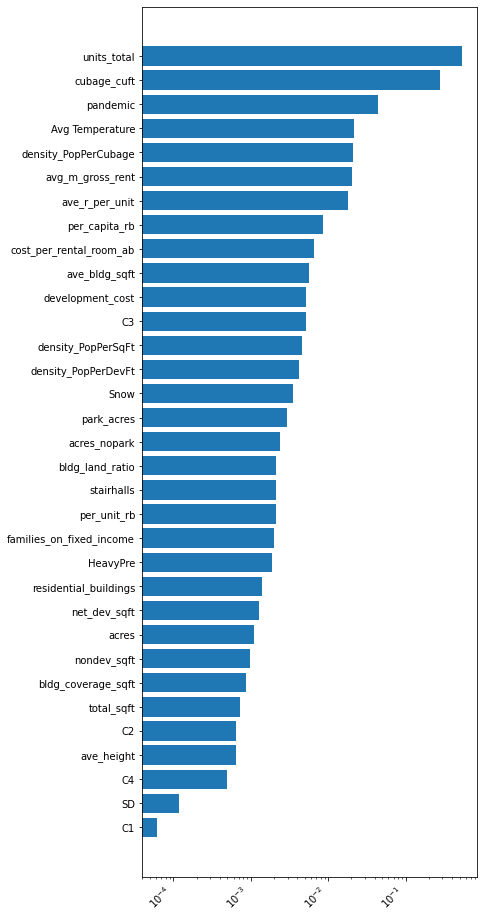

In [106]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by='Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [107]:
result.sort_values(by = 'Importance', ascending=False)

,Predictors,Importance
0,units_total,0.530914
10,cubage_cuft,0.276369
30,pandemic,0.044363
24,Avg Temperature,0.021314
19,density_PopPerCubage,0.021001
15,avg_m_gross_rent,0.020551
16,ave_r_per_unit,0.018166
21,per_capita_rb,0.008678
13,cost_per_rental_room_ab,0.006519
23,ave_bldg_sqft,0.005601


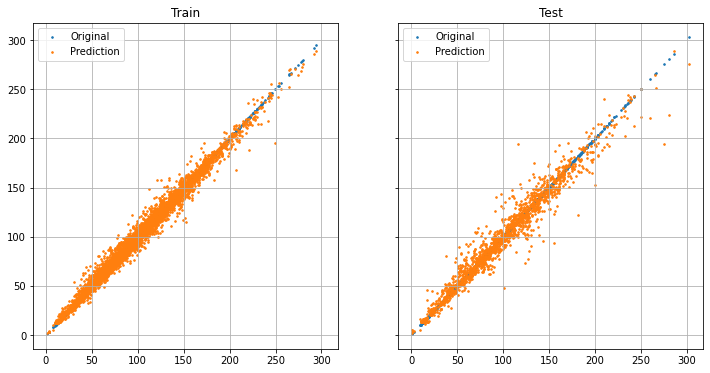

In [108]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

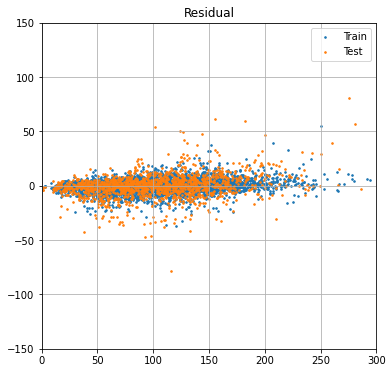

In [109]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [110]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/models/Dataset_without_Outlier/RF.sav'
pickle.dump(clf, open(filename, 'wb'))

## Gradient Boosting

In [111]:
from sklearn.ensemble import GradientBoostingRegressor

In [112]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print("Training score: %.3f" % reg.score(X_train, y_train))
print("Testing score: %.3f" % reg.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.938
Testing score: 0.928
Mean Squared Error: 141.397
Mean Squared Error 176.551


In [113]:
parameters = {'n_estimators':[10, 20 , 50], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth': range(5,15)} 

GBR = GradientBoostingRegressor(random_state=0,loss='squared_error')
reg = GridSearchCV(GBR, parameters, cv=5, scoring='r2')

reg.fit(X_train,y_train)
print('Best parameters:', reg.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50}


In [114]:
reg = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 8, n_estimators= 50)
reg = reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print("Training score: %.3f" % reg.score(X_train, y_train))
print("Testing score: %.3f" % reg.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.988
Testing score: 0.956
Mean Squared Error: 26.275
Mean Squared Error 107.429


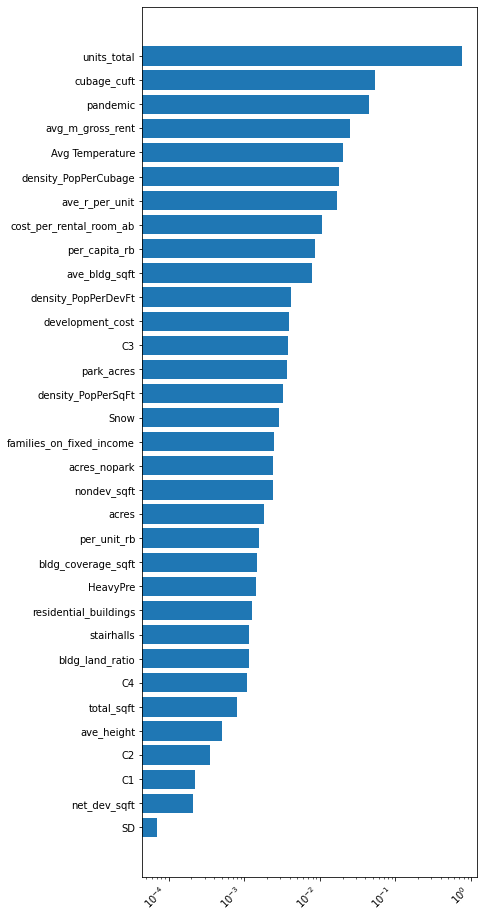

In [115]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = reg.feature_importances_
result = result.sort_values(by='Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

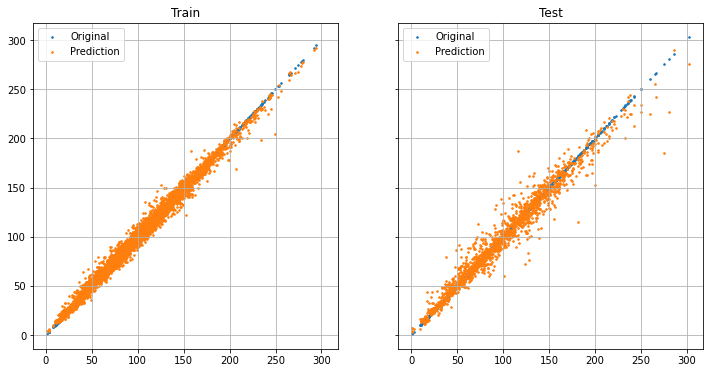

In [116]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

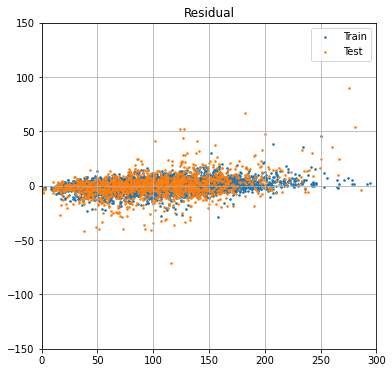

In [117]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [118]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/models/Dataset_without_Outlier/GBRT.sav'
pickle.dump(reg, open(filename, 'wb'))